# Data Preparation
Preparing Natural Scenery data imported from Kaggle

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from tensorflow import keras

IMG_ROWS, IMG_COLS = 150, 150
num_classes = 6

# Defining labels
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_labels = {'mountain': 0,
               'street': 1,
               'glacier': 2,
               'buildings': 3,
               'sea': 4,
               'forest': 5}

train_directory = '../input/intel-image-classification/seg_train/seg_train'
test_directory = '../input/intel-image-classification/seg_test/seg_test'

Using TensorFlow backend.


In [2]:
def prep_data(directory):
    image_list = []
    label_list = []
    for img_folder in tqdm.tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_folder)
        label = class_labels[img_folder]
        for file_path in os.listdir(img_path):
            img = cv2.imread(os.path.join(img_path, file_path))
            img = cv2.resize(img, (IMG_ROWS, IMG_COLS))
            image_list.append(img)
            label_list.append(label)
    image_list, label_list = shuffle(image_list, label_list)
    image_list = np.array(image_list, dtype='float32')
    label_list = np.array(label_list, dtype='int32')
    
    return image_list, label_list

In [3]:
train_images, train_labels = prep_data(train_directory)
test_images, test_labels = prep_data(test_directory)
          
# Ex Path: ../input/intel-image-classification/seg_pred/seg_pred/10004.jpg

100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


In [4]:
print(train_images.shape[1:])

(150, 150, 3)


In [5]:
# Scaling data
train_images = train_images / 255.0
test_images = test_images / 255.0

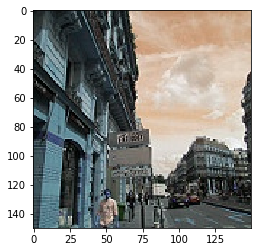

In [6]:
# View random image
index = np.random.randint(train_images.shape[0])
plt.figure()
plt.imshow(train_images[index])
plt.grid(False)
plt.show()

# Create Model

In [7]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D

In [17]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(IMG_ROWS, IMG_COLS, 3)))
model.add(Conv2D(64, kernel_size=3, activation='relu', strides=2))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, kernel_size=3, activation='relu', strides=2))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(Conv2D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# Compile Model

In [18]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 73, 73, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 17, 64)        36928     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 128)      

# Fit Model

In [20]:
model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split=0.2)

Train on 11227 samples, validate on 2807 samples
Epoch 1/10
11227/11227 [==============================] - 7s 628us/sample - loss: 1.2931 - acc: 0.4659 - val_loss: 1.0421 - val_acc: 0.5810
Epoch 2/10
11227/11227 [==============================] - 7s 588us/sample - loss: 0.9888 - acc: 0.5965 - val_loss: 0.9562 - val_acc: 0.6263
Epoch 3/10
11227/11227 [==============================] - 7s 609us/sample - loss: 0.8773 - acc: 0.6508 - val_loss: 0.8727 - val_acc: 0.6662
Epoch 4/10
11227/11227 [==============================] - 7s 585us/sample - loss: 0.7893 - acc: 0.6968 - val_loss: 0.7185 - val_acc: 0.7260
Epoch 5/10
11227/11227 [==============================] - 7s 589us/sample - loss: 0.6609 - acc: 0.7579 - val_loss: 0.6623 - val_acc: 0.7570
Epoch 6/10
11227/11227 [==============================] - 7s 586us/sample - loss: 0.5900 - acc: 0.7891 - val_loss: 0.6194 - val_acc: 0.7805
Epoch 7/10
11227/11227 [==============================] - 7s 589us/sample - loss: 0.5182 - acc: 0.8146 - val_lo

# Evaluate Model

In [21]:
test_loss = model.evaluate(test_images, test_labels)

3000/3000 [==============================] - 1s 268us/sample - loss: 0.4989 - acc: 0.8223


# Testing on an individual landscape picture

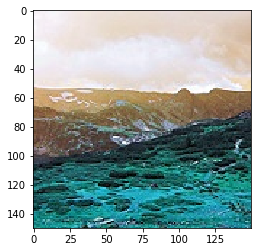

Model prediction: mountain
Real: mountain


In [22]:
index = np.random.randint(test_images.shape[0]) 

img = (np.expand_dims(test_images[index], 0))
pred = model.predict(img)
pred_img = np.argmax(pred[0])
pred_y = class_names[pred_img]
real_y = class_names[test_labels[index]]

plt.figure()
plt.imshow(test_images[index])
plt.grid(False)
plt.show()

print('Model prediction: {}'.format(pred_y))
print('Real: {}'.format(real_y))